# Portfolio optimization

## Import required libraries

In [49]:
# !pip install --user yfinance

In [50]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

# 1: Define Tickers and Time Range

In [51]:
# Define tickers and time range
tickers = ['SPY', # 'SPY': Most popular SnP index
           'BND', # 'BND': Most popular bond index
           'GLD', # 'GLD': Largest commodity based ETF
           'QQQ', # 'QQQ': Largest Nasdaq ETF
           'VTI'  # 'VTI': Entire world stock market
          ]

In [52]:
# Save the end date to today
end_date = datetime.today()

In [53]:
# Grab the date from 5 years ago
start_date = end_date - timedelta(days = 5*365)
print(start_date)

2018-11-28 18:53:21.100346


# 2: Download Adjusted Close Prices

Adjusted close prices includes dividends, stock splits and other financial events.

In [54]:
data = yf.download('SPY', start = start_date, end = end_date)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-28,269.600006,274.579987,268.329987,274.579987,252.594528,127629600
2018-11-29,273.709991,275.549988,272.429993,273.980011,252.042603,82346400
2018-11-30,273.809998,276.279999,273.450012,275.649994,253.578949,98204200
2018-12-03,280.279999,280.399994,277.510010,279.299988,256.936676,103176300
2018-12-04,278.369995,278.850006,269.899994,270.250000,248.611237,177986000
...,...,...,...,...,...,...
2023-11-20,450.529999,455.130005,450.519989,454.260010,454.260010,69936200
2023-11-21,453.179993,454.130005,451.959991,453.269989,453.269989,49244600
2023-11-22,454.980011,456.380005,453.890015,455.019989,455.019989,59394900


In [55]:
# Create an empty DataFrame to store the prices
adj_close_df = pd.DataFrame()

# Download the closer prices for each ticker
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']
    
# Display the DataFrame
adj_close_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2018-11-28,252.594528,68.668808,115.379997,163.182281,129.358841
2018-11-29,252.042603,68.721626,115.739998,162.650284,129.119629
2018-11-30,253.578949,68.748016,115.540001,163.830414,130.048874
2018-12-03,256.936676,68.855598,116.410004,166.693542,131.566956
2018-12-04,248.611237,69.023186,117.120003,160.299728,127.270340
...,...,...,...,...,...
2023-11-20,454.260010,70.739998,183.369995,390.739990,224.789993
2023-11-21,453.269989,70.839996,185.350006,388.470001,224.179993
2023-11-22,455.019989,70.900002,184.559998,390.059998,225.139999


# 3: Calculate the Lognormal Returns

We are using the Lognormal Returns because they can be added to each other to find the final return.

In [56]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [57]:
# We drop the first row because they all or missing values
log_returns = log_returns.dropna()
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2018-11-29,-0.002187,0.000769,0.003115,-0.003265,-0.001851
2018-11-30,0.006077,0.000384,-0.001729,0.007229,0.007171
2018-12-03,0.013154,0.001564,0.007502,0.017325,0.011606
2018-12-04,-0.032939,0.002431,0.006081,-0.039112,-0.033202
2018-12-06,-0.001518,0.001787,0.000171,0.007035,-0.001230
...,...,...,...,...,...
2023-11-20,0.007668,0.001415,-0.001635,0.012101,0.007502
2023-11-21,-0.002182,0.001413,0.010740,-0.005826,-0.002717
2023-11-22,0.003853,0.000847,-0.004271,0.004085,0.004273


# 4: Calculate Covariance Matrix

The cov_matrix argument is a matrix that represents the covariance between the returns of the assets. Covariance measures how two assets move in relation to each other. This matrix is typically square, with its size depending on the number of assets in the portfolio.

In [58]:
# Calculate Covariance Matrix using annualized log returns

cov_matrix = log_returns.cov()*252 # 252 is the typical number 
                                   # of trading days in a year

In [59]:
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.045724,0.002568,0.003100,0.051666,0.046740
BND,0.002568,0.004493,0.003708,0.003188,0.002721
GLD,0.003100,0.003708,0.022074,0.004376,0.003250
QQQ,0.051666,0.003188,0.004376,0.067004,0.052768
VTI,0.046740,0.002721,0.003250,0.052768,0.048152


# 5: Define Portfolio Performance Metrics

## 5.1. Calculate the portfolio standard deviation

``variance = weights.T @ cov_matrix @ weights`` calculates the variance of the portfolio. 

Let's break it down further:
- ``weights.T``: This represents the transpose of the weights array. Transposing converts a row vector into a column vector (or vice versa).
- ``@``: This symbol represents matrix multiplication.
- ``np.sqrt``: This is a function from the NumPy library that calculates the square root of a given number or array.

The expression performs a matrix multiplication in the following order: first, it multiplies the transposed weights vector with the covariance matrix, and then the result of that multiplication is multiplied with the original weights vector.

This operation essentially weights the covariance matrix by the proportion of each asset in the portfolio and sums up the result, yielding the portfolio's variance. Then, the STD is computed.

In [60]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

## 5.2. Calculate the expected return

**Note:** We assume that the expected returns are the average of the past returns. This is an assumption that in real life would be too weak.

In [61]:
# Compute the expected return
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

## 5.3. Calculate the Sharpe Ratio

The Sharpe Ratio is a widely used metric to evaluate the risk-adjusted performance of an investment or a trading strategy. It measures how much excess return you are receiving for the extra volatility that you endure for holding a riskier asset compared to a risk-free asset.

**The mathematical definition is:**

The Sharpe Ratio is defined as the difference between the returns of the investment and the risk-free rate, divided by the standard deviation of the investment's excess return (which is a measure of its volatility or risk).

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

In [62]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns)-risk_free_rate) / standard_deviation(weights, cov_matrix)

## 5.4. Find the Risk-Free Rate

We assume the ``risk_free_rate`` to be 4%.

In [63]:
risk_free_rate = 0.04

# 6: Portfolio Optimization

## 6.1. Set the function to optimize

The function to minimize is the ``sharpe_ratio``. However, since we are going to use ``spicy.optimize.minimize()`` function we need to compute the negative value of the ratop because there is no direct method to find the maximum value of a function. In this way, we will find the most negative value of the ``-sharpe_ratio``.

In [64]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

## 6.2. Set the constraints and bounds

We set that the sum of all of them needs to be 1 and the potential maximum and minimum boundaries for the weights. Since the boundaries are between 0 and 0.8, that means that we cannot sell short (min = 0) and that any asset in the portfolio can be more than 80% of our portfolio. This is because we want to avoid to buy a lot of one asset in case this one was too good in the past 5 years.

In [65]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.8) for weight in range(len(tickers))]

In [66]:
constraints

{'type': 'eq', 'fun': <function __main__.<lambda>(weights)>}

In [67]:
bounds

[(0, 0.8), (0, 0.8), (0, 0.8), (0, 0.8), (0, 0.8)]

## 6.3. Set the initial weights

In [68]:
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [69]:
initial_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

## 6.4. Optimize the weights to maximise Sharpe Ratio

In [70]:
optimized_results = minimize(neg_sharpe_ratio,
                             initial_weights,
                             args=(log_returns, cov_matrix, risk_free_rate),
                             method = 'SLSQP',
                             constraints = constraints,
                             bounds = bounds)

# SLSQP: Sequantial Least Squares Quadratic Programming, 
# which is a numerical optimization technique suitable 
# for solving nonlinear optimization problems with constraints 

In [71]:
optimized_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.6131741874560129
       x: [ 0.000e+00  0.000e+00  5.394e-01  4.606e-01  0.000e+00]
     nit: 5
     jac: [-9.753e-02  5.095e-02 -2.643e-01 -2.654e-01 -3.682e-02]
    nfev: 30
    njev: 5

In [72]:
optimal_weights = optimized_results.x
optimal_weights

array([0.        , 0.        , 0.53942414, 0.46057586, 0.        ])

# 7: Results

## 7.1. Summary

In [73]:
print('The optimal weights are:')

for weight, ticker in zip(optimal_weights, tickers):
    print(f"{ticker}: {weight:.2f}")

portfolio_expected_return = expected_return(optimal_weights, log_returns)
portfolio_standard_deviation = standard_deviation(optimal_weights, cov_matrix)
portfolio_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f'The expected annual return is: {portfolio_expected_return:.4f}')
print(f'The expected volatility is: {portfolio_standard_deviation:.4f}')
print(f'The Sharpe Ratio is: {portfolio_sharpe_ratio:.4f}')


The optimal weights are:
SPY: 0.00
BND: 0.00
GLD: 0.54
QQQ: 0.46
VTI: 0.00
The expected annual return is: 0.1326
The expected volatility is: 0.1510
The Sharpe Ratio is: 0.6132


## 7.2. Visualization

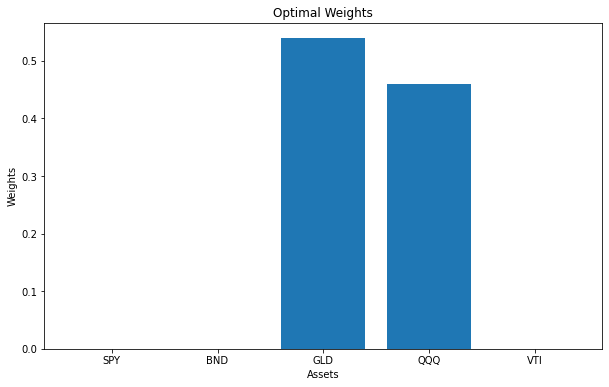

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Weights')
plt.title('Optimal Weights')

plt.show()

# 8: Acknowledgement

This tutorial has been conducted following the video 'Portfolio Optimization in Python: Boost Your Financial Performance', by Ryan O'Connell. <br>
Video available at: <br>
https://www.youtube.com/watch?v=9GA2WlYFeBU&ab_channel=RyanO%27Connell%2CCFA%2CFRM